# New in Forest 2 - Running on the QVM

PyQuil is for constructing and running quantum programs on real quantum computers. With the release of pyQuil 2, we have changed parts of the API (compared to pyQuil 1.x) to better reflect that focus.

## Program construction is largely the same

To construct run-and-measure-style programs, there are no changes in program construction. When using explicit `MEASURE` instructions or using parametric programs for massive speed increases, please read about the [new quil memory model](migration3-declare.ipynb).

Below, we build a program that constructs a Bell state.

In [1]:
from pyquil import Program
from pyquil.gates import *
program = Program(
    H(0),
    CNOT(0, 1),
)
print(program)

H 0
CNOT 0 1



## Unphysical methods deprecated in `QVMConnection`

In pyQuil 1.x, you would use the `QVMConnection` to run quantum programs on a web-hosted quantum simulator (the "Quantum Virtual Machine"). To run on a real quantum processor (QPU), you would switch all instances of `QVMConnection` to `QPUConnection`. However, `QVMConnection` let you do many unphysical operations that are unsupported on a real QPU. These methods are detailed below and have been deprecated in favor of a new API that clearly delineats the physical from the unphysical.

### Wavefunction

When simulating a quantum program, we can inspect its wavefunction. This is very useful! It is--however--impossible to inspect the wavefunction of a real quantum processor. This is one of the central tenets of quantum information!
Attempting to switch instances of `QVMConnection` to `QPUConnection` results in an error. Additionally, using `QVMConnection` with a noise model will cause the `wavefunction` call to behave badly.

#### The old way

In [2]:
from pyquil.api import QVMConnection
wfn_old = QVMConnection().wavefunction(program)
print(wfn_old)

(0.7071067812+0j)|00> + (0.7071067812+0j)|11>


#### The new way

`WavefunctionSimulator` encapsulates all functionality that requires peering into a wavefunction. This also opens the door for different types of simulators other than those backed by a wavefunction. For example, you can simulate a quantum circuit with a density matrix simulation or a path integral simulation.

In [3]:
from pyquil.api import WavefunctionSimulator
wfn = WavefunctionSimulator().wavefunction(program)
print(wfn)

(0.7071067812+0j)|00> + (0.7071067812+0j)|11>


### Expectation

Many quantum algorithms involve calculating expectation values of quantum observables. We can represent quantum observables with `PauliSum`s. When using a simulator, it is possible to exactly calculate expectation values (a consequence of having access to the full wavefunction) whereas when running on a QPU you must estimate expectation values by sampling from many runs of a program.

Let's use our program defined above to construct a bell state.

In [4]:
print(program)

H 0
CNOT 0 1



And we wish to measure the following quantum observables $O$
 - the expected value of the 0th bit $O=(1-Z_0)/2$
 - the expected value of the 1st bit $O=(1-Z_1)/2$
 - the expected value of the exclusive or (XOR) between the two qubits $O=(1-Z_0Z_1)/2$
 
**Exercise for the reader:** convince yourself that $(1-Z_0Z_1)/2$ is the XOR function

In [5]:
from pyquil.paulis import sZ

z0 = (1-sZ(0))*0.5
z1 = (1-sZ(1))*0.5
xor = (1-sZ(0)*sZ(1))*0.5

A Bell state is entangled, so each of the 1-qubit operators should give an expectation value of 0.5 (as each qubit taken individually has a 50% change of being measured in the 0 or 1 state) whereas the two-qubit operator should give an expectation value of 0 (as the two qubits considered together will always have even parity)

#### The old way

Because of technical details, `QVMConnection.expectation` requires transforming your observable represented as a `PauliSum` into a program, and then remembering to multiply back in the coefficients. A more usable API was introduced in Pyquil 1.9 and was given the name `pauli_expectation`.

In [6]:
for observable in [z0, z1, xor]:
    expectation = QVMConnection().pauli_expectation(prep_prog=program, pauli_terms=observable)
    print(observable, '\t', expectation)

(0.5+0j)*I + (-0.5+0j)*Z0 	 (0.4999999999999999+0j)
(0.5+0j)*I + (-0.5+0j)*Z1 	 (0.4999999999999999+0j)
(0.5+0j)*I + (-0.5+0j)*Z0*Z1 	 0j


#### The new way
If you want analytical expectation values, the solution is to use `WavefunctionSimulator.expectation`

Note that the method is not named `pauli_expectation` as we do not support the pyQuil<1.9 way of using `Program`s to represent `PauliSum`s

In [7]:
for observable in [z0, z1, xor]:
    expectation = WavefunctionSimulator().expectation(prep_prog=program, pauli_terms=observable)
    print(observable, '\t', expectation)

(0.5+0j)*I + (-0.5+0j)*Z0 	 (0.4999999999999999+0j)
(0.5+0j)*I + (-0.5+0j)*Z1 	 (0.4999999999999999+0j)
(0.5+0j)*I + (-0.5+0j)*Z0*Z1 	 0j


#### Sampling expectations on a QPU.

Estimating expectation values via *sampling* from a QPU is often something we would like to do! Please look forward for helper functions for sampling observables in the near future.

## Async methods removed

pyQuil 2 is tailored for Rigetti's Quantum Cloud Services (QCS). In prior releases, executing programs on either the QVM or QPU involved communicating with a cloud-hosted endpoint. Now, you are empowered with

 1. A pre-configured quantum machine image (QMI) with your own dedicated qvm and quilc instance.
 2. low-latency QPU access all to yourself during a scheduled time window
 3. A downloadable local version of the qvm and quilc
 
Taken together, there is no longer any motivation for supporting asynchronous access to either the QVM or QPU.

### The old way
When running many programs it was often possible to reduce runtime by batching jobs and exploiting the async queue. The following example does not work in pyQuil 2 but gives a sketch about how this would have worked.

```python
import numpy as np
cxn = QVMConnection()
thetas = np.linspace(0, 2*np.pi, 20)
jobs = [Program(RY(theta, 0)) for theta in thetas]
job_ids = [cxn.run_and_measure_async(job, qubits=[0], trials=1000) for job in jobs]
bitstrings = [np.asarray(cxn.wait_for_job(job)) for job in jobs]
```

### The not-quite-new way

Since this is such an important use case, there have been many changes to support running many programs as quickly as possible. We demonstrate an equivalent, synchronous version of the example given above. **To idiomatically run this set of jobs, there are additional features you should use that are not covered in this document**. Please continue reading the documentation, especially the page covering [parametric programs](migration3-declare.ipynb).

In [8]:
import numpy as np
cxn = QVMConnection()
thetas = np.linspace(0, np.pi, 20)
bitstrings = [np.asarray(cxn.run_and_measure(Program(RY(theta, 0)), qubits=[0], trials=1000))
              for theta in thetas]

### The result

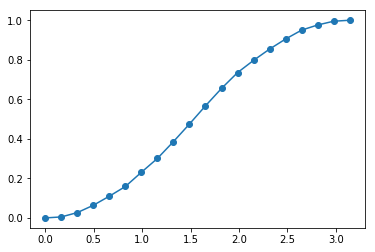

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

averages = [np.mean(bs[:,0]) for bs in bitstrings]
_ = plt.plot(thetas, averages, 'o-')